In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

# Cross-validation/gridserch tools
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import precision_score


# Model fine-tuning and evaluation
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection



# Pipiline tools
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#Deal with outliers
from sklearn.preprocessing import RobustScaler



import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore sklearn/seaborn deprecation warning 

Precision is a good measure to determine, when the costs of False Positive is high.

In [2]:
df = pd.read_csv('./dataset/data_prepared.csv', index_col=0)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 38 to 16144
Data columns (total 16 columns):
monthly_income                1497 non-null int64
monthly_outcome               1497 non-null int64
total_credit_payments         1497 non-null float64
payments_per_year             1497 non-null int64
loan_term                     1497 non-null float64
loan_amount                   1497 non-null float64
_will_pay                     1497 non-null int64
worst_previous_delinquency    1497 non-null float64
worst_previous_fraction       1497 non-null float64
_is_account_recent            1497 non-null int64
_is_common_type               1497 non-null int64
ratio_outcome_income          1497 non-null float64
sqrt_income                   1497 non-null float64
sqrt_outcome                  1497 non-null float64
log_income                    1497 non-null float64
log_outcome                   1497 non-null float64
dtypes: float64(10), int64(6)
memory usage: 198.8 KB


In [3]:
# Split target feature

X = df.drop(labels = ["_will_pay"],axis = 1)
y = df['_will_pay']

#There is an imbalance between class 1 and class 0.
(df['_will_pay'].sum())/ (df['_will_pay'].count())

0.8410153640614563

In [4]:
scaler = StandardScaler()
X_SS = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns) # Helps the most

transformer = RobustScaler().fit(X)
X_RS = pd.DataFrame(transformer.transform(X), index=X.index, columns=X.columns) # Helps marginally

X_train, X_test, y_train, y_test = train_test_split(X_SS, y, test_size=0.2, random_state=42)

# Modeling Round 1

In [5]:
# Initiate 11 classifier models
ran = RandomForestClassifier(random_state=1)
knn = KNeighborsClassifier()
log = LogisticRegression()
xgb = XGBClassifier()
gbc = GradientBoostingClassifier()
svc = SVC(probability=True)
ext = ExtraTreesClassifier()
ada = AdaBoostClassifier()
gnb = GaussianNB()
gpc = GaussianProcessClassifier()
bag = BaggingClassifier()


models_names=['Random Forest', 'K Nearest Neighbour', 
              'Logistic Regression', 'XGBoost', 
              'Gradient Boosting', 'SVC', 'Extra Trees', 
              'AdaBoost', 'Gaussian Naive Bayes', 
              'Gaussian Process', 'Bagging Classifier']



# Prepare lists and dictionary for future use
models = [ran, knn, log, xgb, gbc, svc, ext, ada, gnb, gpc, bag]         
scores = []
models_dict = dict(zip(models_names, models))

# Sequentially fit and cross validate all models
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring ='precision', cv = 10)
    scores.append(acc.mean())

/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rene/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Cross validation presicion scores

In [6]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Score': scores})

result_df = results.sort_values(by='Score', ascending=False).reset_index(drop=True)
result_df.head(11)


,Model,Score
0,Bagging Classifier,0.914901
1,Random Forest,0.912320
2,Extra Trees,0.904734
3,Gradient Boosting,0.895591
4,XGBoost,0.884859
5,K Nearest Neighbour,0.884197
6,AdaBoost,0.878779
7,Gaussian Process,0.864467
8,Gaussian Naive Bayes,0.852353
9,Logistic Regression,0.846096


(0.81, 0.92)

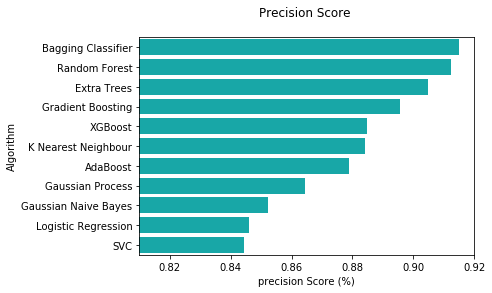

In [7]:
sns.barplot(x='Score', y = 'Model', data = result_df, color = 'c')
plt.title('Precision Score \n')
plt.xlabel('precision Score (%)')
plt.ylabel('Algorithm')
plt.xlim(0.81, 0.92)

## Feature importance

In [8]:
# Function for new graph
def importance_plotting(data, x, y, palette, title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data, y_vars=y, x_vars=x, size=5, aspect=1.5)
    ft.map(sns.stripplot, orient='h', palette=palette, edgecolor="black", size=15)
    
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()
    plt.savefig('./plots_tables/'+title.replace(' ', '_')+'.png')


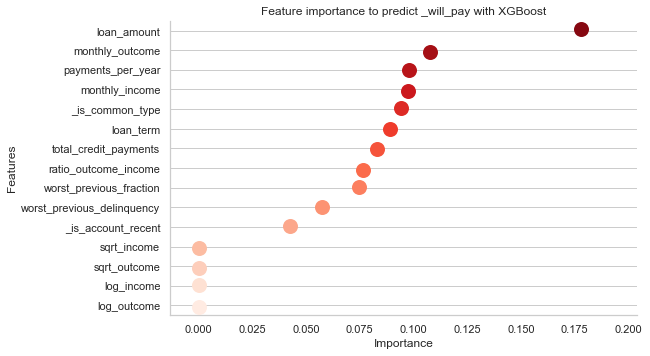

<Figure size 432x288 with 0 Axes>

In [9]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':xgb.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['Feature importance to predict _will_pay with XGBoost']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)


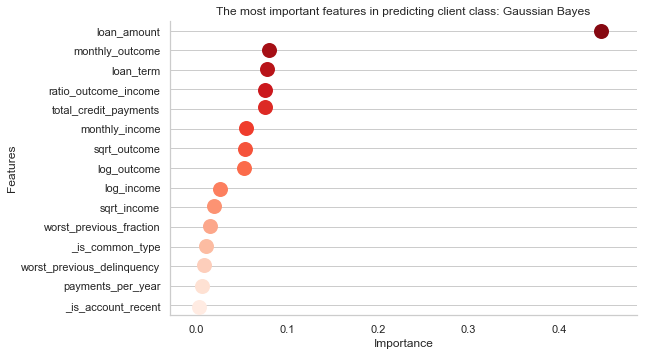

<Figure size 432x288 with 0 Axes>

In [10]:
# Building feature importance into a DataFrame
fi = {'Features':X.columns.tolist(), 'Importance':gbc.feature_importances_}
importance = pd.DataFrame(fi, index=None).sort_values('Importance', ascending=False)

# Creating graph title
titles = ['The most important features in predicting client class: Gaussian Bayes']

# Plotting graph
importance_plotting(importance, 'Importance', 'Features', 'Reds_r', titles)

Something is seriesouly wrong here because the feature importance is very different in both cases. Let's next study the learning curves:

In [11]:
kfold = StratifiedKFold(n_splits=4,shuffle=True, random_state=42)

def plot_learning_curve(estimator, title, X, y, cv=4,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=4, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    plt.savefig('./plots_tables/'+title.replace(' ', '_')+'.png')
    return plt

## Learning curves

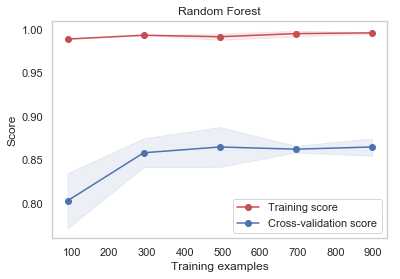

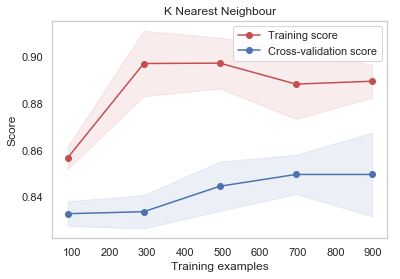

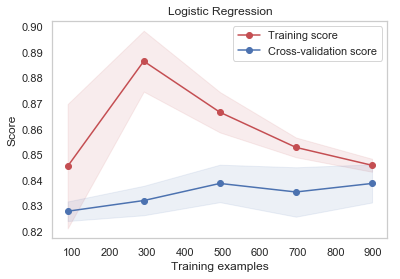

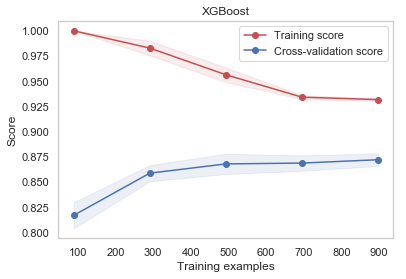

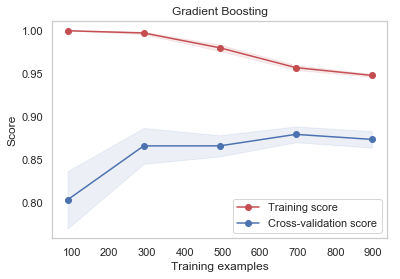

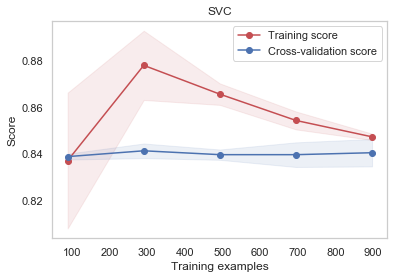

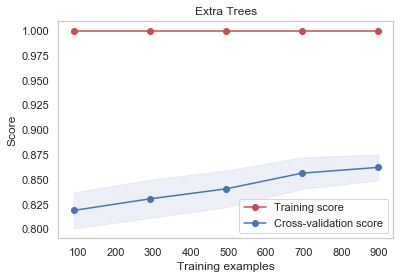

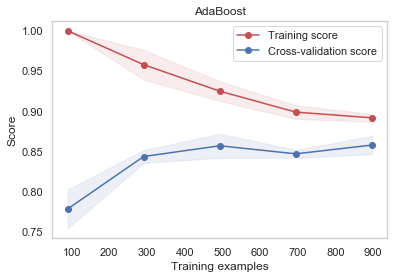

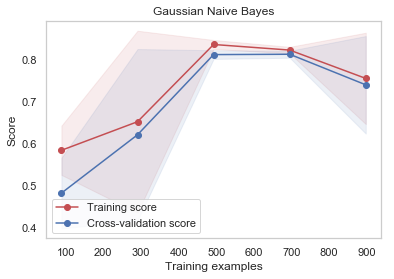

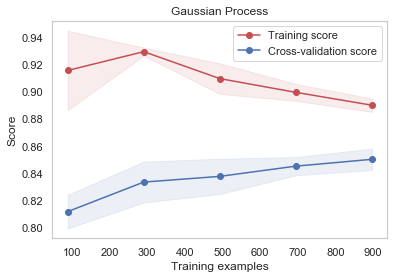

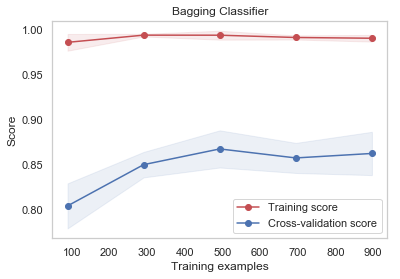

In [12]:
for i in models_names:
    plot_learning_curve(models_dict[i],i,X_train, y_train,cv=kfold)

Learnign curves show that the only models without a Variance problem are:
- Logistic regression
- Support Vector Classifier
- Gaussian process
- Gaussian Naive Bayes
- AdaBoost

# Modeling Round 2: Feature selection 

In [13]:
# Getting feature importances models that include feature_importances_ method
gbc_imp = pd.DataFrame({'Feature':X.columns, 'gbc importance':gbc.feature_importances_})
xgb_imp = pd.DataFrame({'Feature':X.columns, 'xgb importance':xgb.feature_importances_})
ran_imp = pd.DataFrame({'Feature':X.columns, 'ran importance':ran.feature_importances_})
ext_imp = pd.DataFrame({'Feature':X.columns, 'ext importance':ext.feature_importances_})
ada_imp = pd.DataFrame({'Feature':X.columns, 'ada importance':ada.feature_importances_})

# Merging results into a single dataframe
importances = gbc_imp.merge(xgb_imp, on='Feature').merge(ran_imp, on='Feature').merge(ext_imp, on='Feature').merge(ada_imp, on='Feature')

# Calculating average importance per feature
importances['Average'] = importances.mean(axis=1)

# Ranking top to bottom
importances = importances.sort_values(by='Average', ascending=False).reset_index(drop=True)

# Display

importances.to_csv('./plots_tables/feature_importance.csv')

importances



,Feature,gbc importance,xgb importance,ran importance,ext importance,ada importance,Average
0,loan_amount,0.446405,0.178237,0.254905,0.170328,0.20,0.249975
1,ratio_outcome_income,0.075549,0.076709,0.073451,0.069682,0.40,0.139078
2,total_credit_payments,0.075085,0.083232,0.072273,0.090502,0.06,0.076218
3,monthly_outcome,0.079864,0.107628,0.067695,0.075530,0.04,0.074143
4,loan_term,0.077632,0.089134,0.079947,0.076426,0.00,0.064628
5,monthly_income,0.054495,0.097577,0.067143,0.065857,0.02,0.061015
6,log_outcome,0.052152,0.000000,0.063498,0.076819,0.04,0.046494
7,sqrt_outcome,0.053177,0.000000,0.076292,0.082263,0.02,0.046346
8,worst_previous_fraction,0.014440,0.074836,0.032452,0.036491,0.06,0.043644
9,worst_previous_delinquency,0.008401,0.057380,0.026916,0.036034,0.08,0.041746


## Model retraining

In [14]:
# We drop only the least important features 

# Re-build model variables
X_v2=X.drop(['_is_account_recent','_is_common_type','log_income'], axis=1,inplace = False)

scaler = StandardScaler()
X_SS_v2 = pd.DataFrame(scaler.fit_transform(X_v2), index=X_v2.index, columns=X_v2.columns) # Helps the most



X_train, X_test, y_train, y_test = train_test_split(X_SS_v2, y, test_size=0.2, random_state=42)

scores_v2=[]
for mod in models:
    mod.fit(X_train, y_train)
    acc = cross_val_score(mod, X_train, y_train, scoring = "precision", cv = 10)
    scores_v2.append(acc.mean())

In [15]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Original Score': scores,
    'Score with feature selection': scores_v2})

result_df = results.sort_values(by='Score with feature selection', ascending=False).reset_index(drop=True)
result_df.head(11)

,Model,Original Score,Score with feature selection
0,Bagging Classifier,0.914901,0.918325
1,Random Forest,0.912320,0.911611
2,Extra Trees,0.904734,0.901283
3,Gradient Boosting,0.895591,0.894440
4,XGBoost,0.884859,0.886325
5,K Nearest Neighbour,0.884197,0.881362
6,AdaBoost,0.878779,0.878403
7,Gaussian Naive Bayes,0.852353,0.851185
8,Gaussian Process,0.864467,0.845614
9,Logistic Regression,0.846096,0.844751


Accuracy slightly went down. This is expected in view of the variance problem detected by the learning curves

# Modeling Round 3: (hyper-parameter) tuning

In [16]:
models_dict_v3={}

In [17]:
# Random Forest

# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]
max_features = [1, 3, 5, 7]
min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]


# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth, 
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = RandomForestClassifier(), param_grid = hyperparams, 
                cv=4, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[0]]= gd.best_estimator_

print(models_dict_v3[models_names[0]])

0.897092625931646
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [18]:
# KNeighborsClassifier


# Parameter's to search
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20]
algorithm = ['auto']
weights = ['uniform', 'distance']
leaf_size = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]

# Setting up parameter grid
hyperparams = {'algorithm': algorithm, 'weights': weights, 'leaf_size': leaf_size, 
               'n_neighbors': n_neighbors}

# Run GridSearch CV
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, 
                    cv=4, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[1]]= gd.best_estimator_

print(models_dict_v3[models_names[1]])

0.903029856926427
KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')


In [19]:
#Logistic regression

# Parameter's to search
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)

# Setting up parameter grid
hyperparams = {'penalty': penalty, 'C': C}

# Run GridSearch CV
gd=GridSearchCV(estimator = LogisticRegression(), param_grid = hyperparams, 
                    cv=4, scoring = "precision")

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[2]]= gd.best_estimator_

print(models_dict_v3[models_names[2]])

0.8459562064183754
LogisticRegression(C=21.544346900318832, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


In [20]:
#XGBoost

max_depth = [3, 5, 7, 9, 10]
min_child_weight = [2, 3, 5, 6]


hyperparams = {'max_depth': max_depth, 'min_child_weight': min_child_weight,"n_estimators": [90,100,110],
              'reg_alpha':[1e-3, 1e-2, 0.1],"learning_rate": [0.05,0.1]}


gd=GridSearchCV(estimator = XGBClassifier(learning_rate=0.0001, n_estimators=10), param_grid = hyperparams, 
                                           cv=4, scoring = "precision", n_jobs = 4)

gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[3]]= gd.best_estimator_

print(models_dict_v3[models_names[3]])

0.9044166925097235
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=3, missing=None,
       n_estimators=110, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0.001,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


In [21]:
# Parameter's to search
learning_rate = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
n_estimators = [100, 250, 500, 750, 1000, 1500]

# Setting up parameter grid
hyperparams = {'learning_rate': learning_rate, 'n_estimators': n_estimators}

# Run GridSearch CV
gd=GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = hyperparams, 
                    cv=4, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[4]]= gd.best_estimator_

print(models_dict_v3[models_names[4]])

0.9050184302375144
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [22]:

#SVC

# Parameter's to search
Cs = [0.001, 0.01, 0.1, 1, 5, 10, 15, 20, 50, 100]
gammas = [0.001, 0.01, 0.1, 1]

# Setting up parameter grid
hyperparams = {'C': Cs, 'gamma' : gammas}

# Run GridSearch CV
gd=GridSearchCV(estimator = SVC(probability=True), param_grid = hyperparams, 
                cv=4, scoring = "precision", n_jobs= 4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)
models_dict_v3[models_names[5]]= gd.best_estimator_

print(models_dict_v3[models_names[5]])


0.8767780530807988
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [23]:
# Extra trees

# Parameter's to search
n_estimators = [10, 25, 50, 75, 100]
max_depth = [3, None]

min_samples_split = [2, 4, 6, 8, 10]
min_samples_leaf = [2, 4, 6, 8, 10]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_depth': max_depth,
               'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}

# Run GridSearch CV
gd=GridSearchCV(estimator = ExtraTreesClassifier(), param_grid = hyperparams, 
                cv=4, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[6]]= gd.best_estimator_
print(models_dict_v3[models_names[6]])

0.8822383108521312
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


In [24]:
# Parameter's to search
n_estimators = [10, 25, 50, 75, 100, 125, 150, 200]
learning_rate = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'learning_rate': learning_rate}

# Run GridSearch CV
gd=GridSearchCV(estimator = AdaBoostClassifier(), param_grid = hyperparams, 
                cv=4, scoring = "precision", n_jobs = 4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[7]]= gd.best_estimator_
print(models_dict_v3[models_names[7]])

0.889840541469614
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=200, random_state=None)


In [25]:
#Gaussian Naive Bayes

models_dict_v3[models_names[8]]= gnb

print(models_dict_v3[models_names[8]])


GaussianNB(priors=None, var_smoothing=1e-09)


In [26]:
# Gaussian Process

# Parameter's to search
n_restarts_optimizer = [0, 1, 2, 3]
max_iter_predict = [1, 2, 5, 10, 20, 35, 50, 100]
warm_start = [True, False]

# Setting up parameter grid
hyperparams = {'n_restarts_optimizer': n_restarts_optimizer, 'max_iter_predict': max_iter_predict, 'warm_start': warm_start}

# Run GridSearch CV
gd=GridSearchCV(estimator = GaussianProcessClassifier(), param_grid = hyperparams, 
                cv=4, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[9]]= gd.best_estimator_
print(models_dict_v3[models_names[9]])

0.8456367352861729
GaussianProcessClassifier(copy_X_train=True, kernel=None, max_iter_predict=2,
             multi_class='one_vs_rest', n_jobs=None,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=True)


In [27]:
# Baggin classifier

# Parameter's to search
n_estimators = [10, 15, 20, 25, 50, 75, 100, 150]
max_samples = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 50]
max_features = [1, 3, 5, 7]

# Setting up parameter grid
hyperparams = {'n_estimators': n_estimators, 'max_samples': max_samples}

# Run GridSearch CV
gd=GridSearchCV(estimator = BaggingClassifier(), param_grid = hyperparams, 
                cv=4, scoring = "precision", n_jobs=4)

# Fitting model and return results
gd.fit(X_train, y_train)
print(gd.best_score_)

models_dict_v3[models_names[10]]= gd.best_estimator_
print(models_dict_v3[models_names[10]])

0.8820359962163298
BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=15,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False)


In [28]:
scores_v3=[]
for mod in models_dict_v3:
    models_dict_v3[mod].fit(X_train, y_train)
    acc = cross_val_score(models_dict_v3[mod], X_train, y_train, scoring = "precision", cv = 5)
    scores_v3.append(acc.mean())

In [29]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Original Score': scores,
    'Score with feature selection': scores_v2,
    'Score with tuned parameters': scores_v3})

result_df = results.sort_values(by='Score with tuned parameters', ascending=False).reset_index(drop=True)


result_df.to_csv('./plots_tables/cross_precision_scores.csv')
result_df.head(11)


,Model,Original Score,Score with feature selection,Score with tuned parameters
0,K Nearest Neighbour,0.884197,0.881362,0.909927
1,Gradient Boosting,0.895591,0.894440,0.905919
2,AdaBoost,0.878779,0.878403,0.899996
3,XGBoost,0.884859,0.886325,0.896798
4,Random Forest,0.912320,0.911611,0.894258
5,Bagging Classifier,0.914901,0.918325,0.882050
6,Extra Trees,0.904734,0.901283,0.877693
7,SVC,0.844523,0.842096,0.877136
8,Gaussian Naive Bayes,0.852353,0.851185,0.853773
9,Logistic Regression,0.846096,0.844751,0.846385


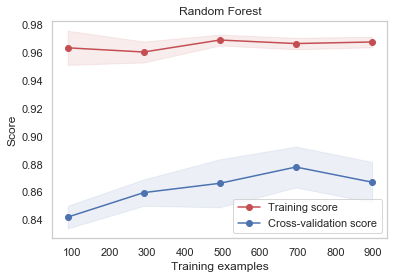

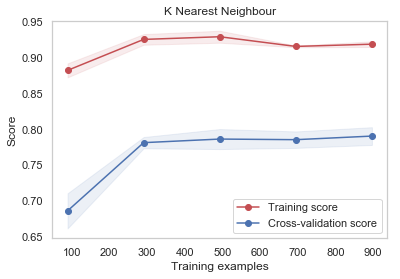

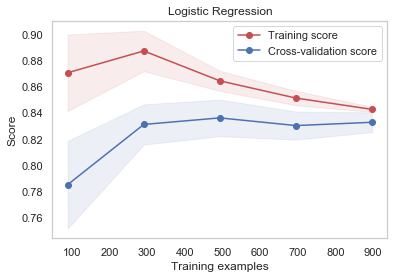

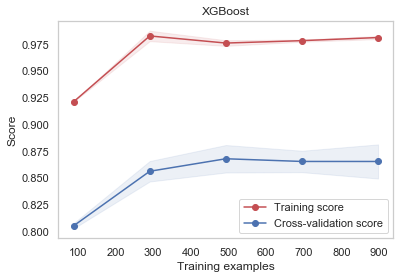

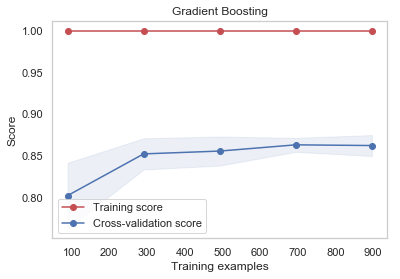

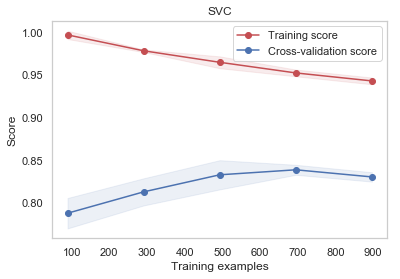

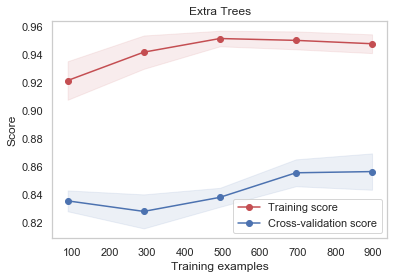

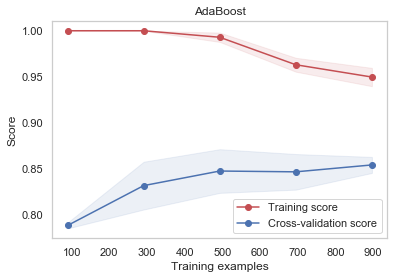

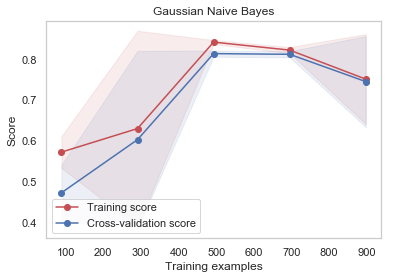

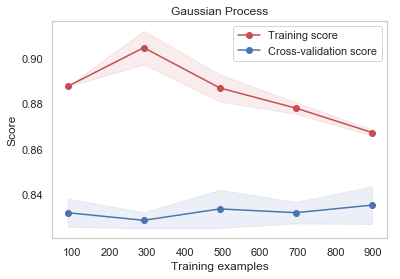

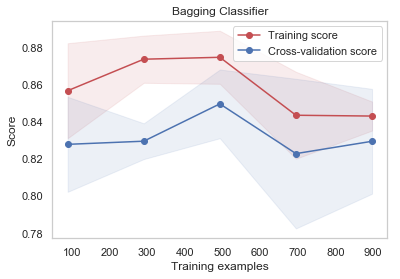

In [30]:
for i in models_names:
    plot_learning_curve(models_dict_v3[i], i , X_train, y_train,cv=kfold)

## Precision on testing set of individual models

In [31]:
from sklearn.metrics import precision_score
scores_test=[]
for mod in models_dict_v3:
    predictions=(models_dict_v3[mod].predict(X_test))
    scores_test.append(precision_score(y_test,predictions))


In [32]:
# Creating a table of results, ranked highest to lowest
results = pd.DataFrame({
    'Model': models_names,
    'Score with feature selection and tuned hy-parameters': scores_v3,
    'Score on test set': scores_test})

result_df = results.sort_values(by='Score on test set', ascending=False).reset_index(drop=True)

result_df.to_csv('./plots_tables/test_set_precision_scores.csv')

result_df.head(11)

,Model,Score with feature selection and tuned hy-parameters,Score on test set
0,K Nearest Neighbour,0.909927,0.931330
1,XGBoost,0.896798,0.906367
2,Random Forest,0.894258,0.903346
3,Gradient Boosting,0.905919,0.901515
4,AdaBoost,0.899996,0.886861
5,SVC,0.877136,0.882784
6,Extra Trees,0.877693,0.882143
7,Bagging Classifier,0.882050,0.875000
8,Gaussian Process,0.845711,0.863014
9,Gaussian Naive Bayes,0.853773,0.861210


In [33]:
import pickle

for key, values in models_dict_v3.items():
    
    pickle.dump(values, open('./trained_models/'+key.replace(' ','_'), 'wb'))


In [34]:
## Definitely better than random! 

## Blending models through voting.

In [35]:
models_dict_blending={k: models_dict_v3[k] for k in models_dict_v3.keys() & {'K Nearest Neighbour', 'XGBoost', 'Gradient Boosting','Extra Trees','Random Forest'}}


In [36]:
# split blending train/cv

votingC = VotingClassifier(estimators= list(models_dict_blending.items()) , voting='soft', n_jobs = -1)

cv_result=cross_val_score(votingC, X_train, y = y_train, scoring = 'precision', cv = kfold, n_jobs = -1)

cv_result.mean(), cv_result.std()


(0.904060503722929, 0.010982277986784073)

In [37]:
# So final precision we got from this data set is:

votingC = votingC.fit(X_train, y_train)
precision_score(y_test, votingC.predict(X_test))

0.9107806691449815

In [38]:
pickle.dump(votingC, open('./trained_models/'+'blended', 'wb'))